### 🧩 Imports

Import all the necessary libraries:
- `json` for reading/writing JSON files.
- `pandas` and `numpy` for data manipulation.
- `random` for generating random synthetic data.
- `IsolationForest` from `sklearn` for anomaly detection.
- `joblib` for saving the trained model.

In [1]:
import os
import json
import pandas as pd
import numpy as np
import random
import joblib
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

### 📊 Generate Dataset

Create synthetic "normal" network traffic data to train an anomaly detection model. Each sample includes:

- `src_port`: randomly selected from common service ports.
- `dst_port`: a random high port number.
- `packet_size`: typical packet sizes.
- `duration_ms`: duration of the communication.
- `protocol`: randomly selected between TCP and UDP.

This data is saved to `training_data.json` for future use.

In [2]:

# ✅ ساخت پوشه خروجی
os.makedirs("dataset", exist_ok=True)

# ✅ تابع تولید داده
def generate_data(n_normal=900, n_anomalous=100):
    COMMON_PORTS = [80, 443, 22, 8080]
    SUSPICIOUS_PORTS = [6666, 9999, 1337]

    def generate_normal():
        return {
            "src_port": random.choice(COMMON_PORTS),
            "dst_port": random.randint(1024, 65535),
            "packet_size": random.randint(100, 1500),
            "duration_ms": random.randint(50, 500),
            "protocol": random.choice(["TCP", "UDP"])
        }

    def generate_anomaly():
        return {
            "src_port": random.choice(SUSPICIOUS_PORTS),
            "dst_port": random.randint(1, 1023),
            "packet_size": random.choice([0, 10, 5000]),
            "duration_ms": random.randint(1000, 5000),
            "protocol": random.choice(["TCP", "UDP"])
        }

    dataset = [generate_normal() for _ in range(n_normal)] + [generate_anomaly() for _ in range(n_anomalous)]
    random.shuffle(dataset)
    return dataset


In [3]:

# ✅ تولید و ذخیره داده
data = generate_data()
with open("dataset/training_data.json", "w") as f:
    json.dump(data, f, indent=2)

# ✅ بارگذاری داده
with open("dataset/training_data.json") as f:
    raw_data = json.load(f)

df = pd.DataFrame(raw_data)


### 🧼 Preprocessing Function

Machine learning models like Isolation Forest require **numerical input only**. Any categorical variables, such as the `protocol` column (`TCP`, `UDP`), must be converted into numbers.

We handle this with **one-hot encoding**, using `pd.get_dummies`.

#### 🛠️ Preprocessing Steps:

1. **Identify categorical columns**:
   - In our case, the `protocol` column is categorical (`TCP`, `UDP`).

2. **Use `pd.get_dummies`**:
   - This creates a new binary column for each category.
   - For instance:
     ```
     protocol
     ---------
     TCP   →   protocol_UDP = 0
     UDP   →   protocol_UDP = 1
     ```
   - Setting `drop_first=True` prevents multicollinearity by dropping the first category (`TCP` here), as it can be inferred from the others.

3. **Return a DataFrame with all numerical values**:
   - This is ready for model input.

> ✅ This preprocessing is essential to avoid errors during training and ensure the model can learn from categorical variables.

In [4]:
# def preprocess_data(df):
     #TODO 1: Implement preprocessing steps
#     return np.array(df)

def preprocess_data(df):
    df_processed = pd.get_dummies(df, columns=["protocol"], drop_first=True)
    return df_processed

df_processed = preprocess_data(df)

### 🤖 Train Isolation Forest

The `IsolationForest` algorithm is an unsupervised model used to detect anomalies. It isolates observations by randomly selecting features and splitting values.

- `n_estimators=100`: number of trees in the forest.
- `contamination=0.01`: assumes 1% of the data is anomalous.
- `random_state=42`: ensures reproducibility.

The model is trained on the preprocessed numerical dataset.

In [5]:
#model = IsolationForest(contamination=0.1, random_state=42)
# model.fit()


# ✅ آموزش مدل
model = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)
model.fit(df_processed)



,n_estimators,100
,max_samples,'auto'
,contamination,0.1
,max_features,1.0
,bootstrap,False
,n_jobs,None
,random_state,42
,verbose,0
,warm_start,False


### 💾 Save Trained Model

Save the trained model using `joblib`, which allows for efficient serialization and deserialization. This saved model can be reused later for inference or deployment.


In [6]:
joblib.dump(model, "anomaly_model.joblib")

['anomaly_model.joblib']

# predict data

In [7]:
# ✅ پیش‌بینی
predictions = model.predict(df_processed)
df["Prediction"] = predictions

print("\n🔍 تعداد نمونه‌های ناهنجار و نرمال:")
print(np.unique(predictions, return_counts=True))


🔍 تعداد نمونه‌های ناهنجار و نرمال:
(array([-1,  1]), array([100, 900]))


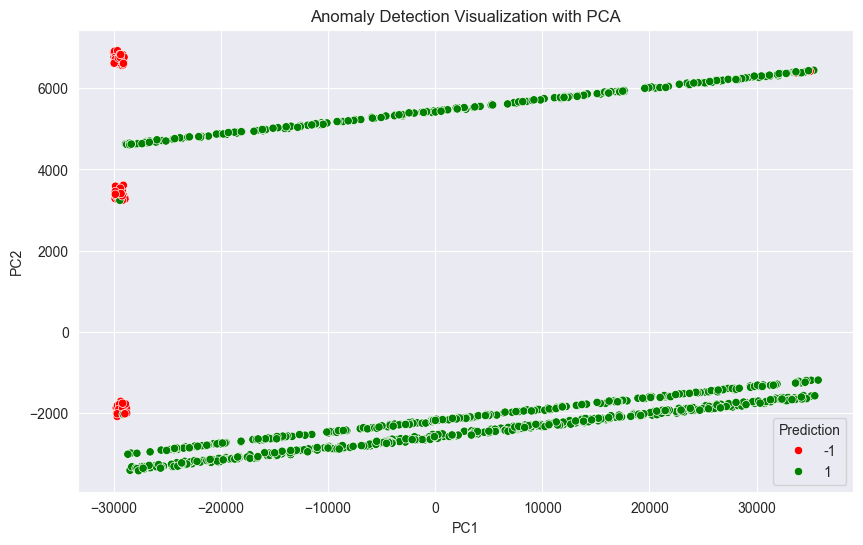

In [8]:
# ✅ تجسم با PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(df_processed)

viz_df = pd.DataFrame(reduced_data, columns=["PC1", "PC2"])
viz_df["Prediction"] = predictions

palette = {1: "green", -1: "red"}

plt.figure(figsize=(10, 6))
sns.scatterplot(data=viz_df, x="PC1", y="PC2", hue="Prediction", palette=palette)
plt.title("Anomaly Detection Visualization with PCA")
plt.grid(True)
plt.show()

In [9]:
# ✅ ذخیره ناهنجاری‌ها
anomalies = df[df["Prediction"] == -1]
anomalies.to_csv("anomalies.csv", index=False)
print(f"\n✅ {len(anomalies)} anomalies saved to 'anomalies.csv'")


✅ 100 anomalies saved to 'anomalies.csv'


In [10]:

# ✅ محاسبه Score و ذخیره
scores = model.decision_function(df_processed)
df["Score"] = scores

anomalies_with_score = df[df["Prediction"] == -1]
anomalies_with_score.to_csv("anomalies_with_score.csv", index=False)

print("\n🔎 Top 5 anomalies by confidence:")
print(anomalies_with_score.sort_values(by="Score").head())



🔎 Top 5 anomalies by confidence:
     src_port  dst_port  packet_size  duration_ms protocol  Prediction  \
584      9999       176         5000         4769      TCP          -1   
236      6666       915         5000         4784      TCP          -1   
89       1337       530         5000         4851      TCP          -1   
125      6666       875         5000         4883      UDP          -1   
774      9999       464         5000         4846      UDP          -1   

        Score  
584 -0.148235  
236 -0.137972  
89  -0.136901  
125 -0.136459  
774 -0.133718  
